In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline
import healpy as hp
from rubin_sim.selfcal import generate_catalog, OffsetSys, OffsetSNR, LsqrSolver
import sqlite3
from rubin_sim.data import get_baseline
import os
from rubin_sim.utils import healbin
import time

runtime= 10.2 min for u
runtime= 8.1 min for g
runtime= 18.7 min for r
runtime= 22.2 min for i
runtime= 19.3 min for z
runtime= 20.5 min for y


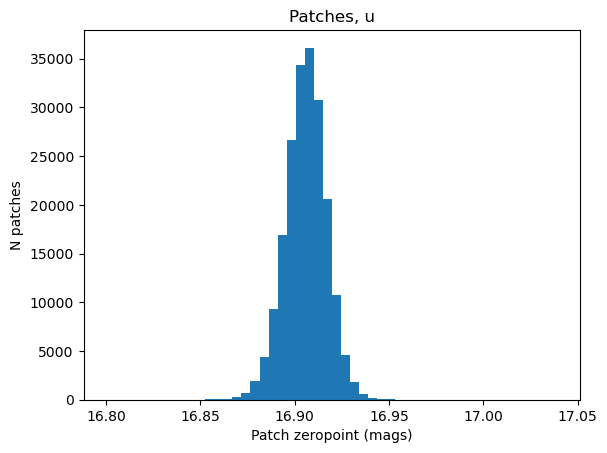

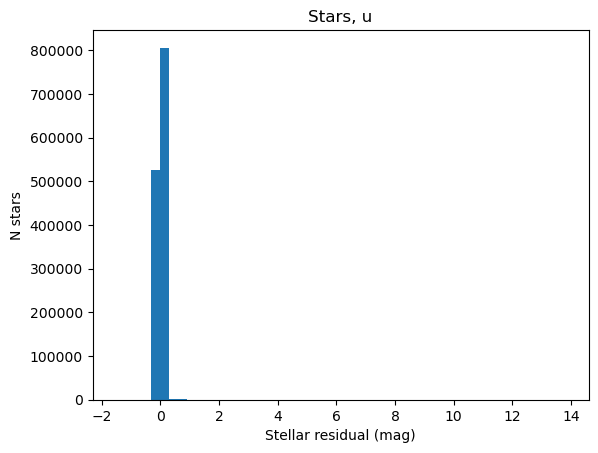

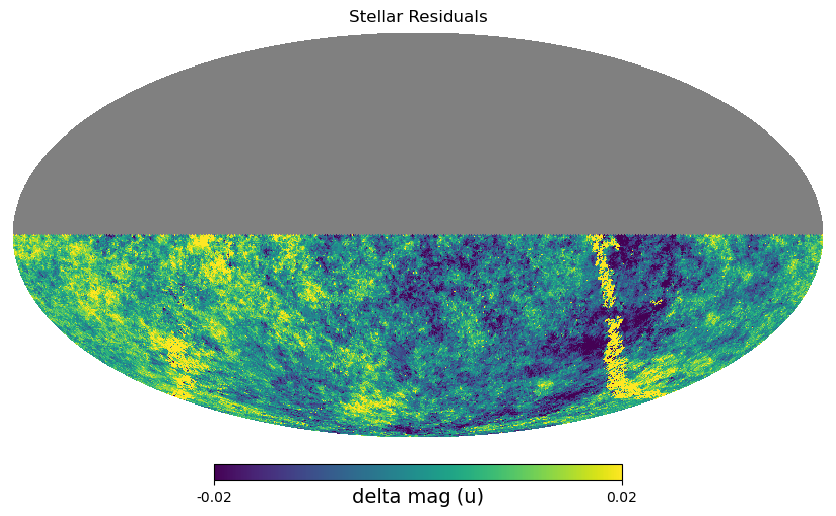

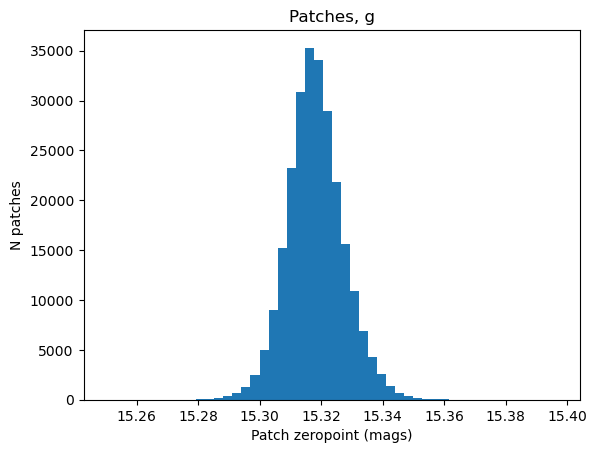

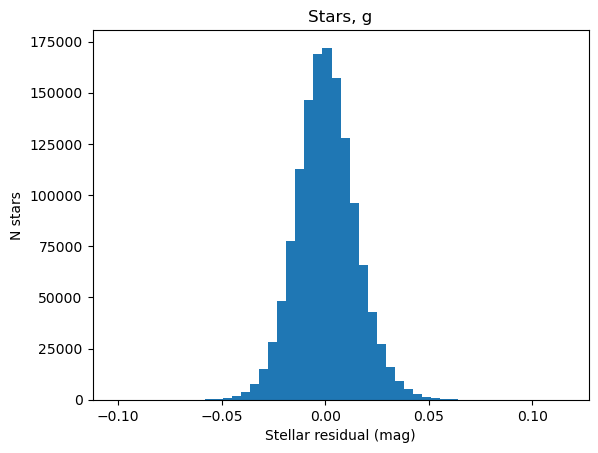

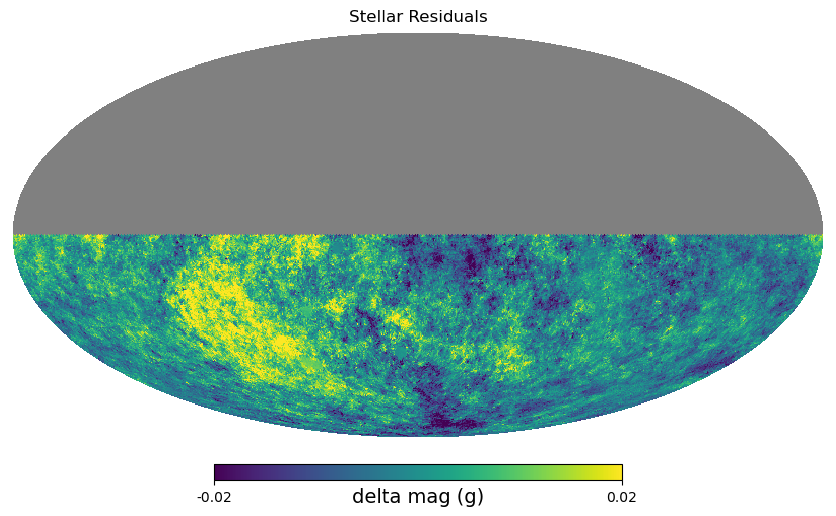

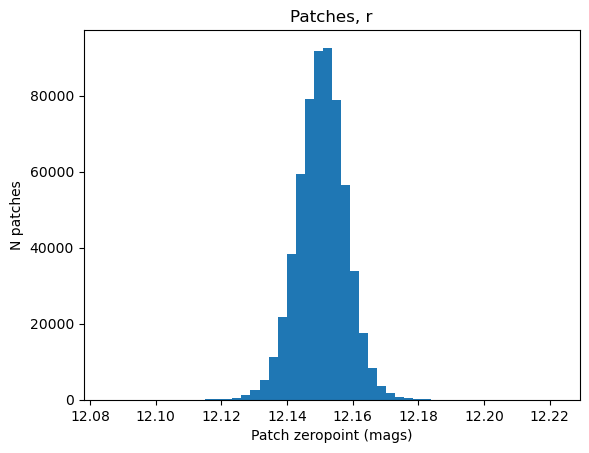

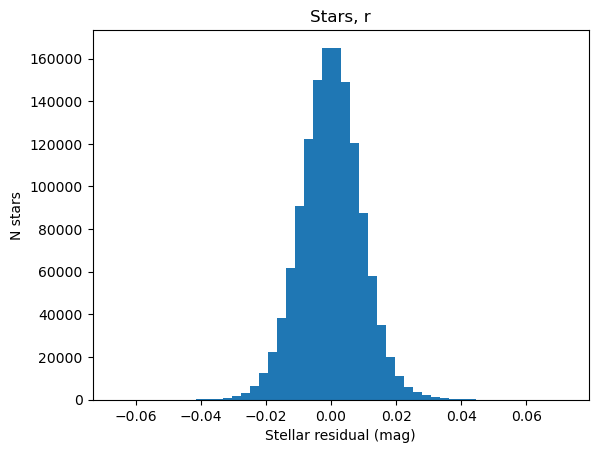

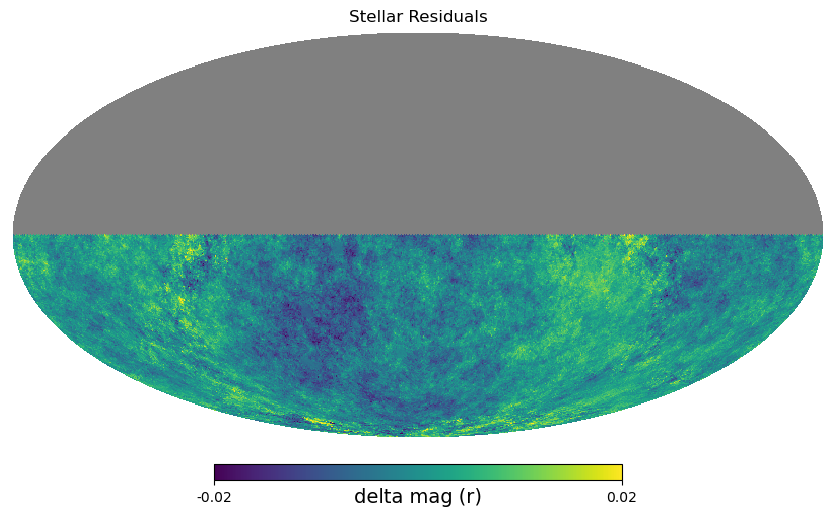

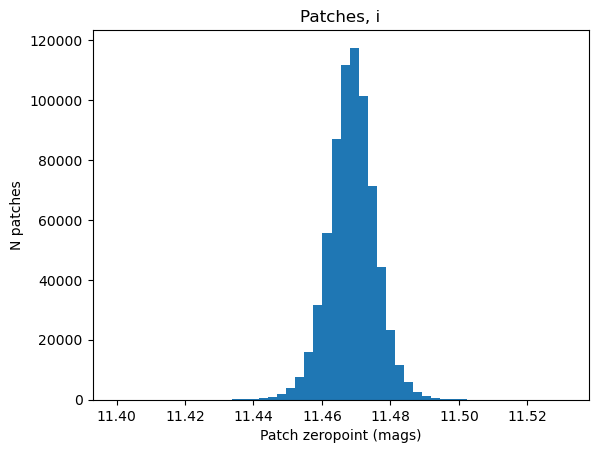

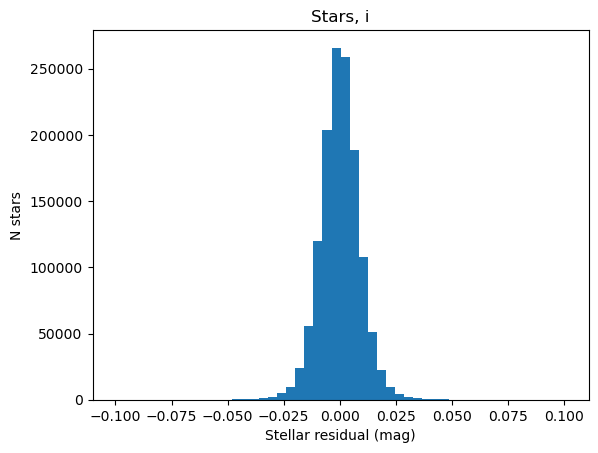

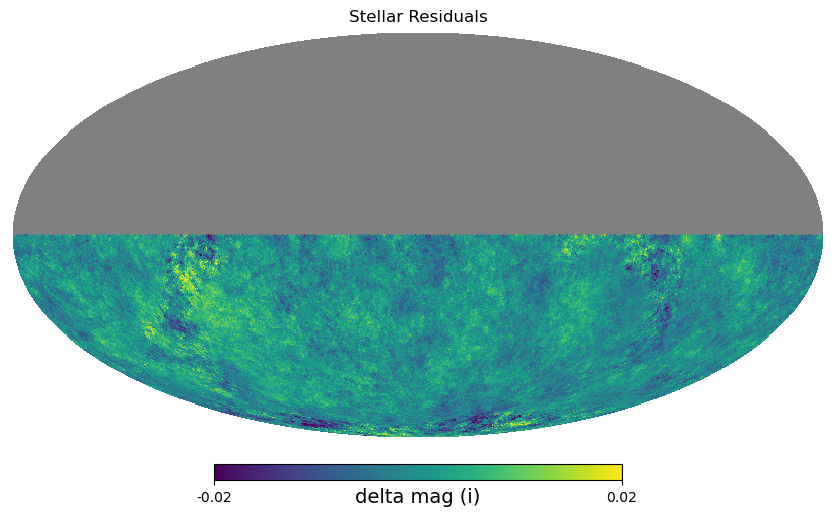

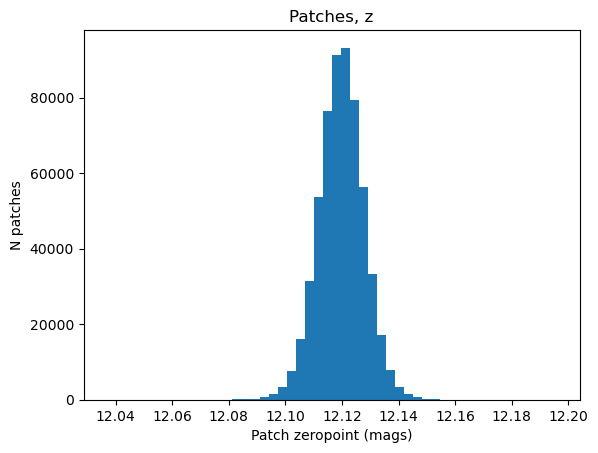

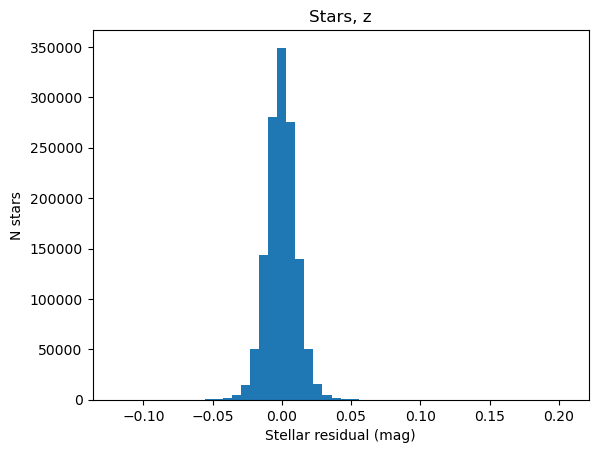

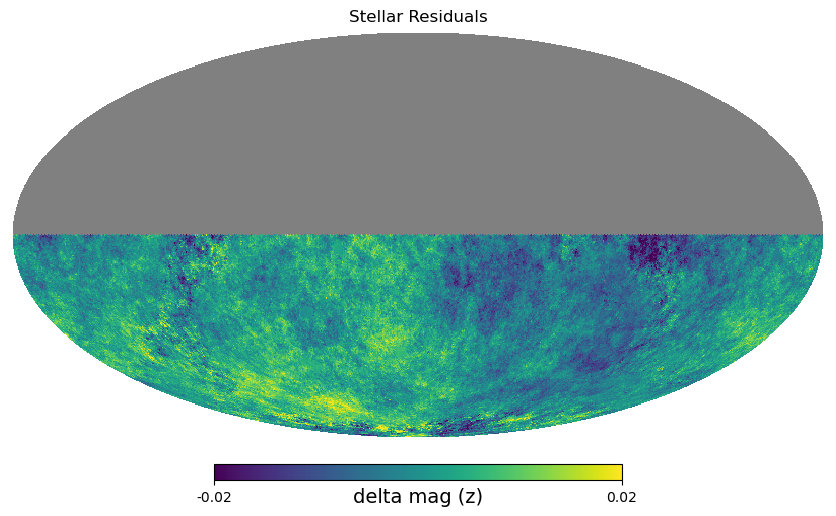

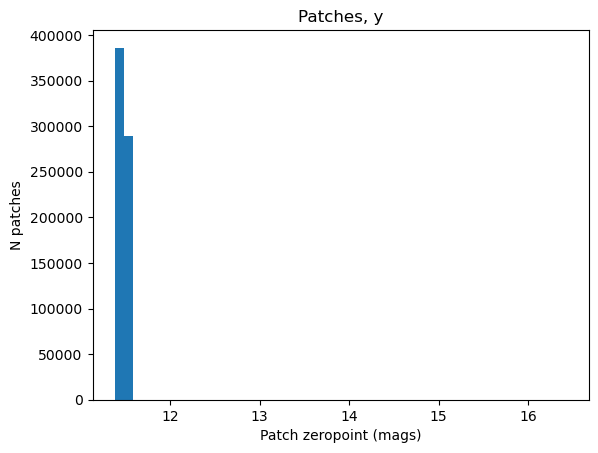

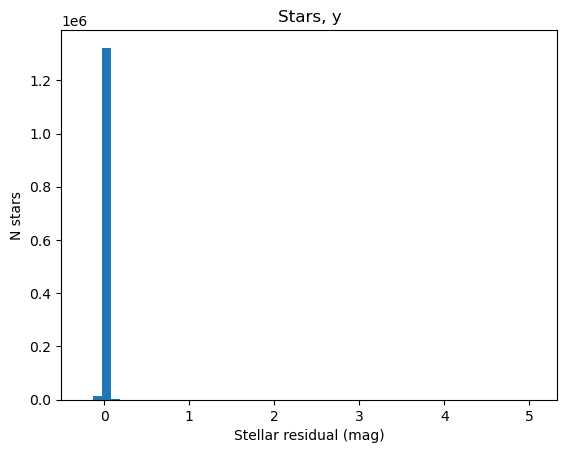

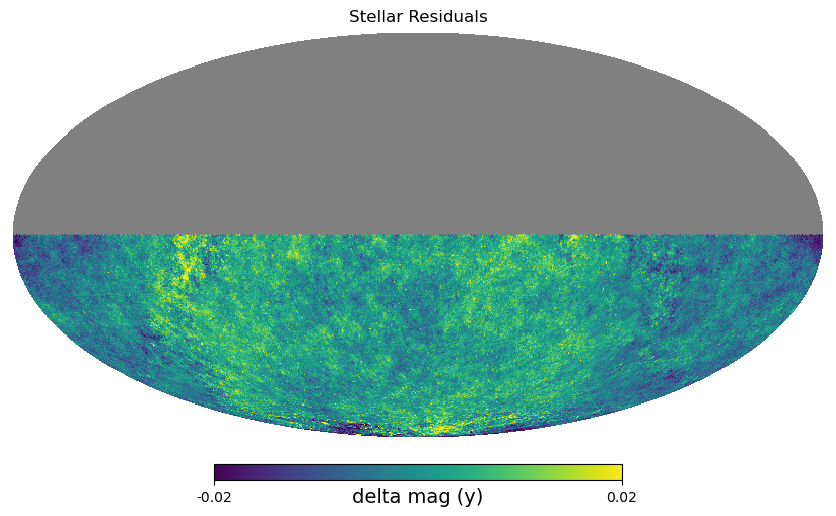

In [2]:
resids = {}
for filter_name in 'ugrizy':
    survey = 'ender_a1_v3.1_10yrs.db'
    con = sqlite3.connect(survey)
    # read with pandas
    visits_df = pd.read_sql("select observationId, fieldra as ra,fielddec as "
                            "dec,fiveSigmaDepth,rotSkyPos "
                            "from observations where filter='%s' and night < 365;" % filter_name, con)
    con.close()

    # Dump the dataframe into a simple numpy array. The to_numpy() method doesn't handle mixed dtypes well
    names = ['observationId', 'ra', 'dec', 'fiveSigmaDepth', 'rotSkyPos']
    types = [int, float, float, float, float]
    visits = np.empty(visits_df.shape[0], dtype=list(zip(names, types)))
    for key in names:
        visits[key] = visits_df[key].values

    # Read the stars in
    con = sqlite3.connect("msrgb_1e6.sqlite")
    stars_df = pd.read_sql("select id,ra,decl,%smag from stars;" % filter_name, con)
    con.close()
    # Repackage as numpy array
    names = ['id', 'ra', 'decl', '%smag' % filter_name]
    types = [int, float, float, float]
    stars = np.empty(stars_df.shape[0], dtype=list(zip(names, types)))
    for key in names:
        stars[key] = stars_df[key].values


    # Set offsets to apply. Doing a 3% systematic to make sure there is some good noise
    # The idea here is one can subclass BaseOffset and add all kinds of offsets to the 
    # observed stellar magnitudes. You could have a radial gradient on the FoV, put in 
    # some cloud structure, whatever you want. For now, let's just add a 0.03 mag 
    # Gaussian systematic noise, and noise based on the SNR of each observation.
    offsets = [OffsetSys(error_sys=0.03), OffsetSNR(lsst_filter=filter_name)]

    observed_stars = generate_catalog(visits, stars, offsets=offsets,
                                      lsst_filter=filter_name, n_patches=16, verbose=False)

    # Construct the matrix. 
    solver = LsqrSolver(observed_stars)

    # run the solver and return the best fit values for each patch and star

    # This will clean the data (eliminate patches that have only 1 star), then run LSQR from scipy
    # This can take a while to grind out.
    t0 = time.time()

    solver.run()
    fit_patches, fit_stars = solver.return_solution()
    t1 = time.time()
    dt = (t1-t0)/60.
    print("runtime= %.1f min for %s" % (dt, filter_name))

    # how the patches converged. We have no flux standards included, so this can drift to an arbitrary zeropoint.
    plt.figure()
    _temp = plt.hist(fit_patches['zp'], bins=50)
    plt.xlabel('Patch zeropoint (mags)')
    plt.ylabel('N patches')
    plt.title('Patches, %s' % filter_name)


    # trim down truth stars to only the ones we got solutions for
    stars_trimmed = stars[np.in1d(stars['id'], fit_stars['id'])]

    # Residuals after fit, removing floating zeropoint
    resid = stars_trimmed['%smag' % filter_name] - fit_stars['fit_mag']
    resid = resid - np.median(resid) 
    
    resids[filter_name] = resid

    plt.figure()
    _temp = plt.hist(resid, bins=50)
    plt.xlabel('Stellar residual (mag)')
    plt.ylabel('N stars')
    plt.title('Stars, %s' % filter_name)

    resid_map = healbin(stars_trimmed["ra"], stars_trimmed["decl"], resid, 128, reduce_func=np.mean)
    hp.mollview(resid_map, min=-0.02, max=0.02, title='Stellar Residuals', unit='delta mag (%s)' % filter_name)